<a href="https://colab.research.google.com/github/Sony2058/Quantum-Classical-Hybrid-Model-for-MNIST-Classification/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install git+https://github.com/mit-han-lab/torchquantum.git
!pip install matplotlib


  Cloning https://github.com/mit-han-lab/torchquantum.git to /tmp/pip-req-build-kypelvo6
  Running command git clone --filter=blob:none --quiet https://github.com/mit-han-lab/torchquantum.git /tmp/pip-req-build-kypelvo6
  Resolved https://github.com/mit-han-lab/torchquantum.git to commit 57f19172981b8e1d360038a62bec53e157f3a57d
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of pathos to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 103.0 MB/s eta 0:00:0

[2025-09-03 15:38:33.020] Only use the front 75 images as TEST set.


Epoch 1:
0.005
valid set accuracy: 0.816597510373444
valid set loss: 0.5205234289169312
Epoch 1: Train loss=0.5770, Val acc=0.8166, Val loss=0.5205
Epoch 2:
0.0049987664009143295
valid set accuracy: 0.8365145228215768
valid set loss: 0.4887881577014923
Epoch 2: Train loss=0.4994, Val acc=0.8365, Val loss=0.4888
Epoch 3:
0.00499506682107068
valid set accuracy: 0.8473029045643153
valid set loss: 0.47457391023635864
Epoch 3: Train loss=0.4790, Val acc=0.8473, Val loss=0.4746
Epoch 4:
0.004988904911507701
valid set accuracy: 0.870539419087137
valid set loss: 0.45803436636924744
Epoch 4: Train loss=0.4626, Val acc=0.8705, Val loss=0.4580
Epoch 5:
0.004980286753286196
valid set accuracy: 0.8788381742738589
valid set loss: 0.44246000051498413
Epoch 5: Train loss=0.4460, Val acc=0.8788, Val loss=0.4425
Epoch 6:
0.004969220851487845
valid set accuracy: 0.8863070539419087
valid set loss: 0.43257665634155273
Epoch 6: Train loss=0.4330, Val acc=0.8863, Val loss=0.4326
Epoch 7:
0.004955718126821723

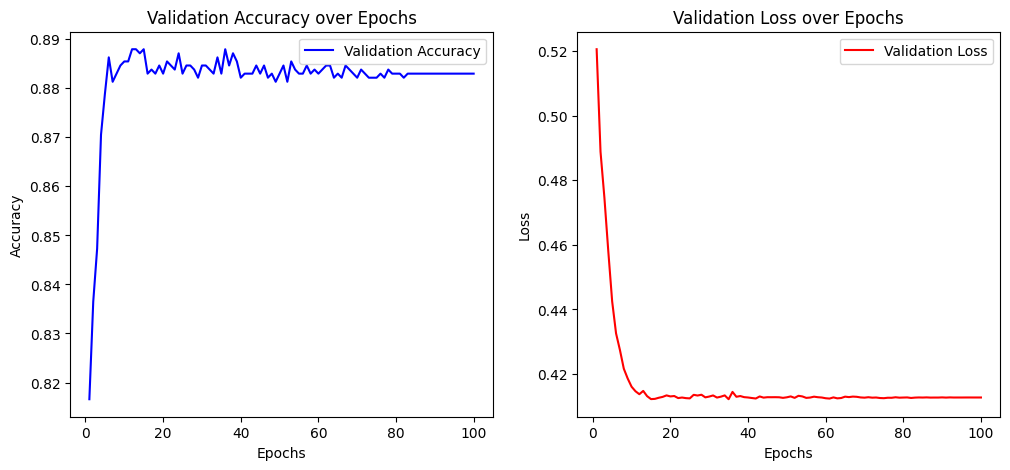

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt

import torchquantum as tq
from torchquantum.plugin import (
    tq2qiskit_measurement,
    qiskit_assemble_circs,
    op_history2qiskit,
    op_history2qiskit_expand_params,
)

from torchquantum.dataset import MNIST
from torch.optim.lr_scheduler import CosineAnnealingLR


class QFCModel(tq.QuantumModule):
    class QLayer(tq.QuantumModule):
        def __init__(self):
            super().__init__()
            self.n_wires = 4
            self.random_layer = tq.RandomLayer(
                n_ops=50, wires=list(range(self.n_wires))
            )

            # gates with trainable parameters
            self.rx0 = tq.RX(has_params=True, trainable=True)
            self.ry0 = tq.RY(has_params=True, trainable=True)
            self.rz0 = tq.RZ(has_params=True, trainable=True)
            self.crx0 = tq.CRX(has_params=True, trainable=True)

        def forward(self, qdev: tq.QuantumDevice):
            self.random_layer(qdev)

            # some trainable gates (instantiated ahead of time)
            self.rx0(qdev, wires=0)
            self.ry0(qdev, wires=1)
            self.rz0(qdev, wires=3)
            self.crx0(qdev, wires=[0, 2])

            # add some more non-parameterized gates (add on-the-fly)
            qdev.h(wires=3)  # type: ignore
            qdev.sx(wires=2)  # type: ignore
            qdev.cnot(wires=[3, 0])  # type: ignore
            qdev.rx(
                wires=1,
                params=torch.tensor([0.1]),
                static=self.static_mode,
                parent_graph=self.graph,
            )  # type: ignore

    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.encoder = tq.GeneralEncoder(tq.encoder_op_list_name_dict["4x4_u3_h_rx"])

        self.q_layer = self.QLayer()
        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, x, use_qiskit=False):
        qdev = tq.QuantumDevice(
            n_wires=self.n_wires, bsz=x.shape[0], device=x.device, record_op=True
        )

        bsz = x.shape[0]
        x = F.avg_pool2d(x, 6).view(bsz, 16)
        devi = x.device

        if use_qiskit:
            # use qiskit to process the circuit
            # create the qiskit circuit for encoder
            self.encoder(qdev, x)
            op_history_parameterized = qdev.op_history
            qdev.reset_op_history()
            encoder_circs = op_history2qiskit_expand_params(self.n_wires, op_history_parameterized, bsz=bsz)

            # create the qiskit circuit for trainable quantum layers
            self.q_layer(qdev)
            op_history_fixed = qdev.op_history
            qdev.reset_op_history()
            q_layer_circ = op_history2qiskit(self.n_wires, op_history_fixed)

            # create the qiskit circuit for measurement
            measurement_circ = tq2qiskit_measurement(qdev, self.measure)

            # assemble the encoder, trainable quantum layers, and measurement circuits
            assembled_circs = qiskit_assemble_circs(
                encoder_circs, q_layer_circ, measurement_circ
            )

            # call the qiskit processor to process the circuit
            x0 = self.qiskit_processor.process_ready_circs(qdev, assembled_circs).to(  # type: ignore
                devi
            )
            x = x0

        else:
            # use torchquantum to process the circuit
            self.encoder(qdev, x)
            qdev.reset_op_history()
            self.q_layer(qdev)
            x = self.measure(qdev)

        x = x.reshape(bsz, 2, 2).sum(-1).squeeze()
        x = F.log_softmax(x, dim=1)

        return x


def train(dataflow, model, device, optimizer):
    epoch_loss = 0
    for feed_dict in dataflow["train"]:
        inputs = feed_dict["image"].to(device)
        targets = feed_dict["digit"].to(device)

        outputs = model(inputs)
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    return epoch_loss / len(dataflow["train"].dataset)


def valid_test(dataflow, split, model, device):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict["image"].to(device)
            targets = feed_dict["digit"].to(device)

            outputs = model(inputs)

            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")

    return accuracy, loss



def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=100, help="number of training epochs")
    args = parser.parse_args(args=[])  # For Colab: prevent argparse error

    seed = 0
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    dataset = MNIST(
        root="./mnist_data",
        train_valid_split_ratio=[0.9, 0.1],
        digits_of_interest=[3, 6],
        n_test_samples=75,
    )
    dataflow = dict()

    for split in dataset:
        sampler = torch.utils.data.RandomSampler(dataset[split])
        dataflow[split] = torch.utils.data.DataLoader(
            dataset[split],
            batch_size=256,
            sampler=sampler,
            num_workers=8,
            pin_memory=True,
        )

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model = QFCModel().to(device)

    n_epochs = args.epochs
    optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        # train
        print(f"Epoch {epoch}:")
        train_loss = train(dataflow, model, device, optimizer)
        print(optimizer.param_groups[0]["lr"])

        # valid
        val_acc, val_loss = valid_test(dataflow, "valid", model, device)

        train_losses.append(train_loss)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train loss={train_loss:.4f}, Val acc={val_acc:.4f}, Val loss={val_loss:.4f}")
        scheduler.step()

    # test
    test_acc, test_loss = valid_test(dataflow, "test", model, device)
    print(f"\nTest set accuracy: {test_acc:.4f}, Test set loss: {test_loss:.4f}")


    epochs_range = range(1, args.epochs + 1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, val_accuracies, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, val_losses, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Epochs')
    plt.legend()


    plt.show()

if __name__ == "__main__":
    main()
